In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df=pd.read_csv("Fraud.csv")

### Show Top 5 Records

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Shape of the dataset

In [4]:
df.shape

(6362620, 11)

### Summary of the dataset

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


### Check Datatypes in the dataset

In [6]:
# Check Dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


- dtypes: float64(5), int64(3), object(3)

### Check Null 

In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

- there is no null values so we are good to go

### EXPLORING DATA

In [8]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 8 numerical features : ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']

We have 3 categorical features : ['type', 'nameOrig', 'nameDest']


## Feature Information

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [9]:
# proportion of count data on categorical columns
for col in categorical_features:
    print("feature--->",col,"Total categories-->",len(df[col].value_counts()))
    print(df[col].value_counts(normalize=True) * 100)
    print('---------------------------')

feature---> type Total categories--> 5
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: type, dtype: float64
---------------------------
feature---> nameOrig Total categories--> 6353307
C1902386530    0.000047
C363736674     0.000047
C545315117     0.000047
C724452879     0.000047
C1784010646    0.000047
                 ...   
C98968405      0.000016
C720209255     0.000016
C1567523029    0.000016
C644777639     0.000016
C1280323807    0.000016
Name: nameOrig, Length: 6353307, dtype: float64
---------------------------
feature---> nameDest Total categories--> 2722362
C1286084959    0.001776
C985934102     0.001713
C665576141     0.001650
C2083562754    0.001603
C248609774     0.001587
                 ...   
M1470027725    0.000016
M1330329251    0.000016
M1784358659    0.000016
M2081431099    0.000016
C2080388513    0.000016
Name: nameDest, Length: 2722362, dtype: float64
---------------------------


**observation**
- we can perform categorical encoding for type feature
- nameOrig , nameDest  have too much classes  , especially number of classes in nameOrig is same as tota record so it will not contribute in our prediction

## Univariate Analysis


The term univariate analysis refers to the analysis of one variable prefix “uni” means “one.” The purpose of univariate analysis is to understand the distribution of values for a single variable.

###  Numerical Features

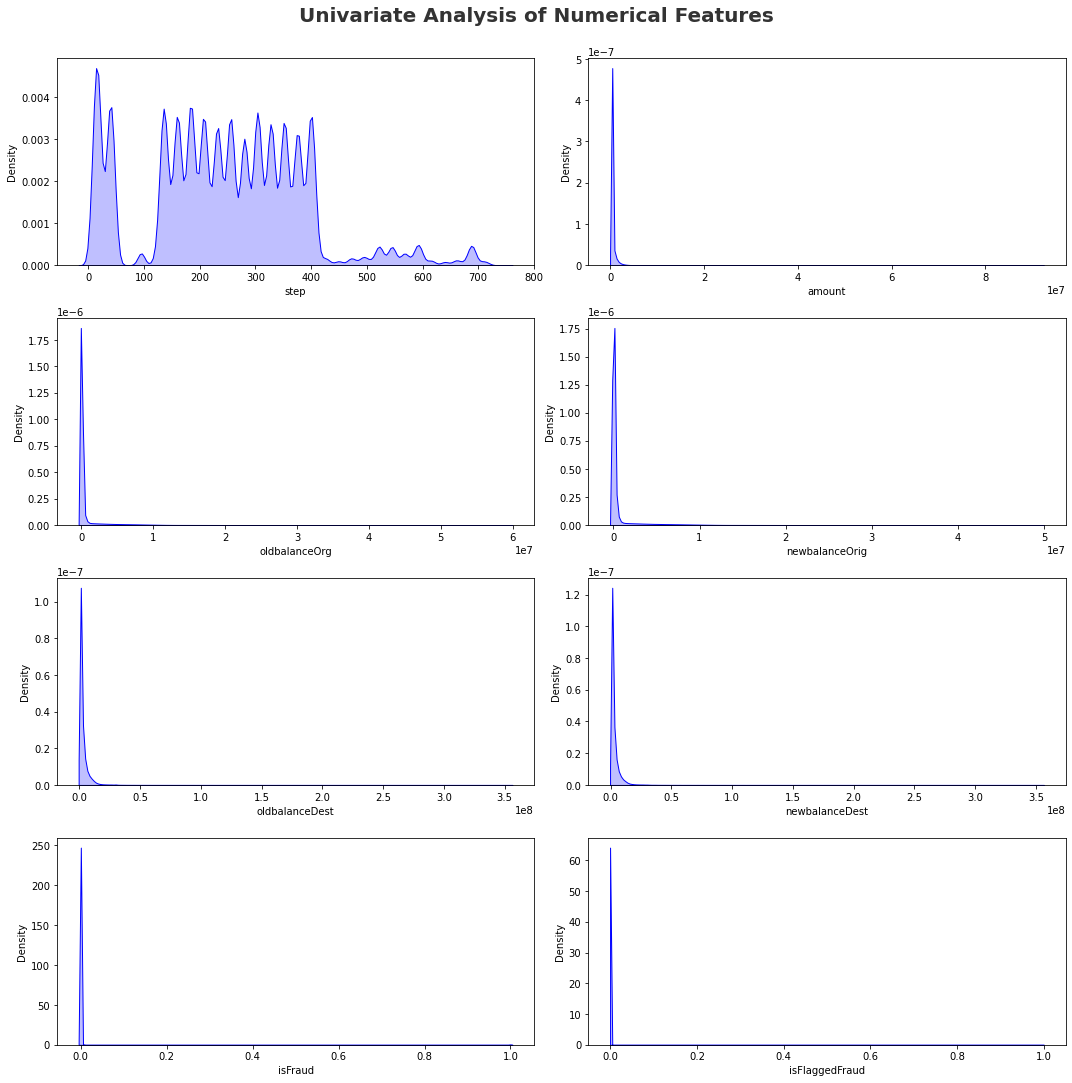

In [10]:
plt.figure(figsize=(15, 15))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)

for i in range(0, len(numeric_features)):
    plt.subplot(4, 2, i+1)
    sns.kdeplot(x=df[numeric_features[i]],shade=True, color='b')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

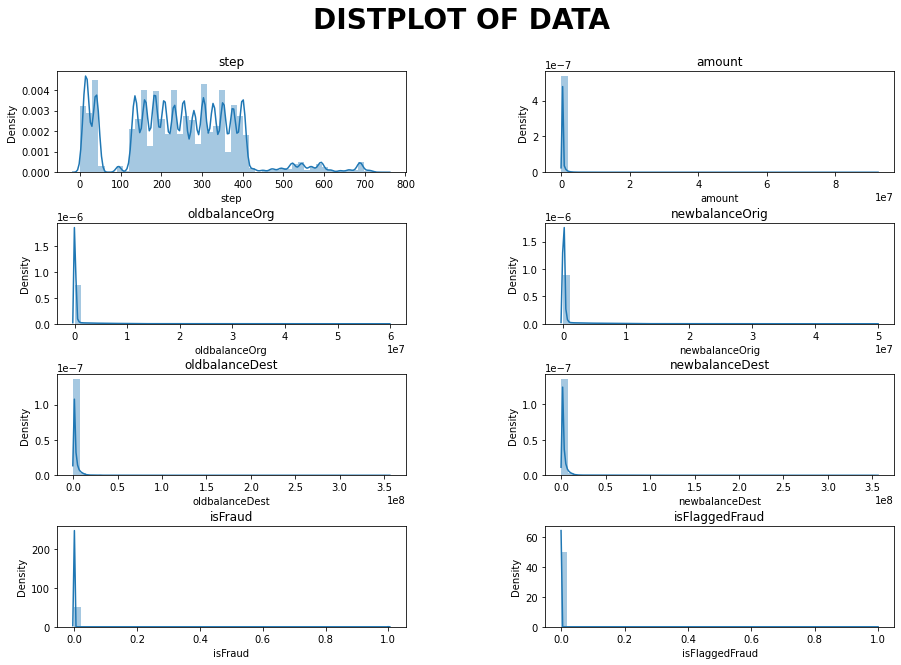

In [11]:
fig = plt.figure(figsize=(15, 15))
fig.suptitle('DISTPLOT OF DATA', fontsize=28, fontweight='bold')
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(numeric_features):  
    ax1 = fig.add_subplot(6,2, i+1);
    ax1 = sns.distplot(df[col]);
 
    ax1.set_title(f'{col}') 
    ax1.set_xlabel(f'{col}')

**observation**
- amount ,oldbalanceOrg ,newbalanceOrig, oldbalanceDest, newbalanceDest  features are skewed right so there may be outluers there 
- not getting much information regarding step features

In [12]:
numeric_features

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

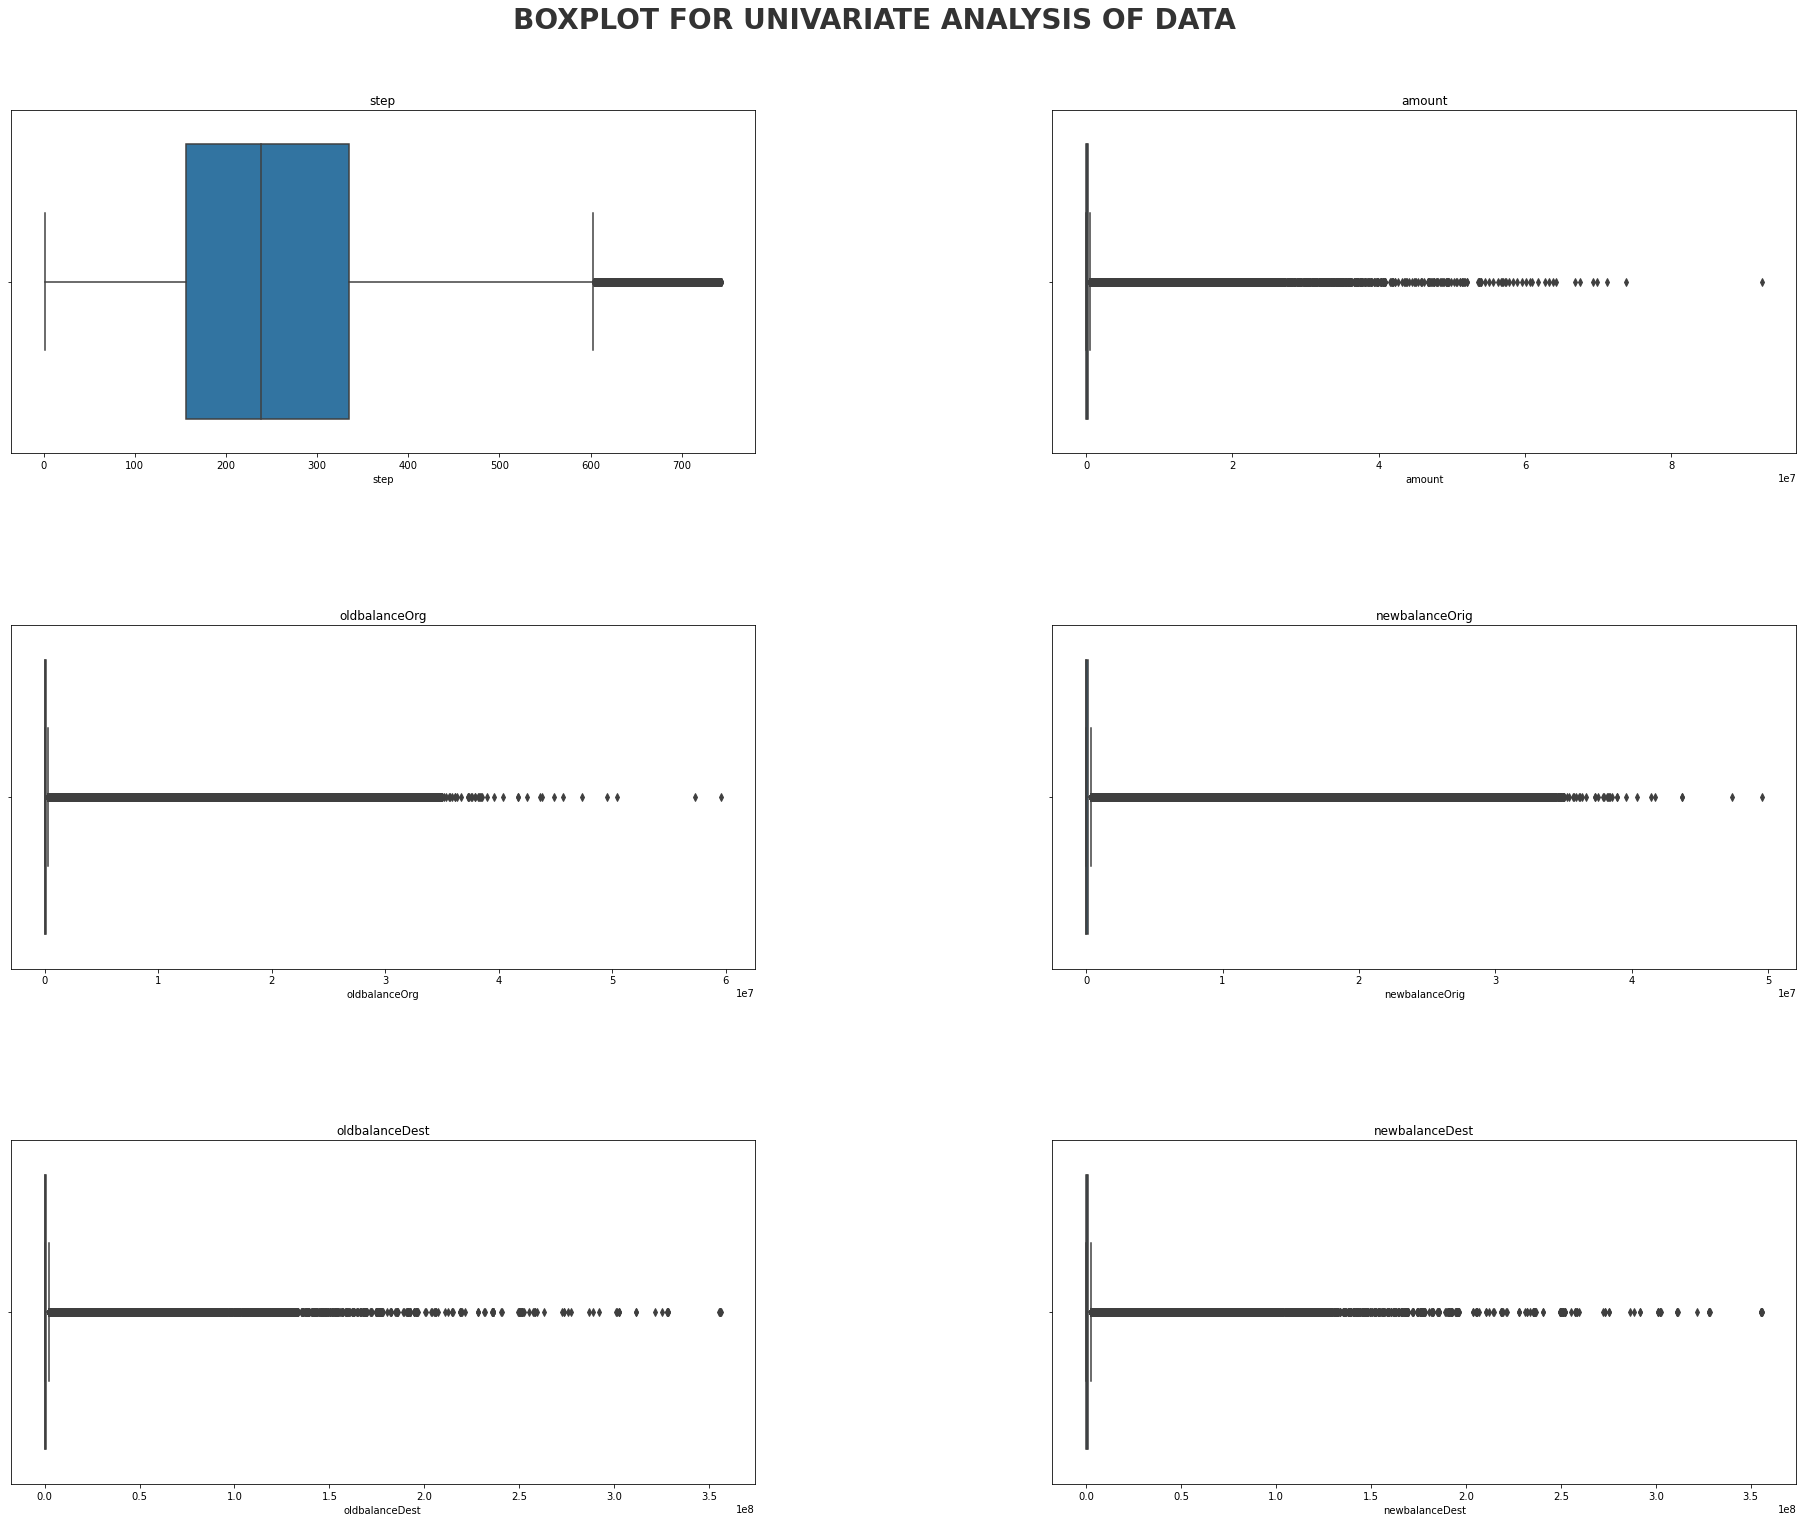

In [13]:
features =['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']
fig = plt.figure(figsize=[32,24])
fig.suptitle('BOXPLOT FOR UNIVARIATE ANALYSIS OF DATA', fontsize=28, fontweight='bold', alpha=0.8,)
fig.subplots_adjust(top=0.92);
fig.subplots_adjust(hspace=0.5, wspace=0.4);
for i ,col in enumerate(features):  
    ax1 = fig.add_subplot(3,2, i+1);
    ax1 = sns.boxplot(data = df, x=col,);
 
    ax1.set_title(f'{col}') 
    ax1.set_xlabel(f'{col}')

- most of the Features are having outliers
- but in this case outliers are important so not going to remove any outliers

In [14]:
numeric_features


['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

**checking   isFraud , isFlaggedFraud features**

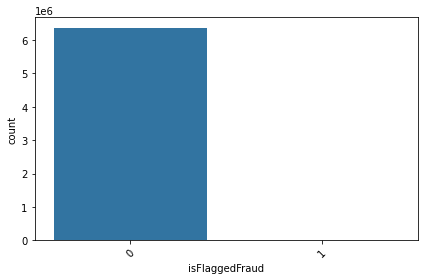

In [15]:
sns.countplot(x=df["isFlaggedFraud"])
plt.xlabel("isFlaggedFraud")
plt.xticks(rotation=45)
plt.tight_layout()

In [16]:
df["isFlaggedFraud"].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

according to the information provided
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

**checking transfer amount for isFlaggedFraud ==1**

In [17]:
df[df['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


**checking transfer amount for isFlaggedFraud ==0**

In [18]:
df[df['isFlaggedFraud']==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


- A lot of transactions that are passing of 200.000 between accounts and isFlaggedFraud == 0 and isFraud==1
- so we will not use this feature

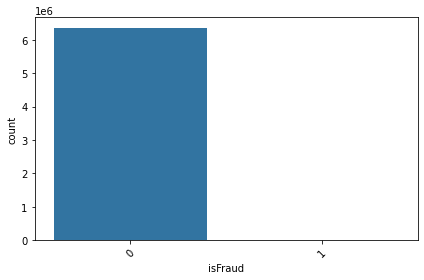

In [19]:
# target column
sns.countplot(x=df["isFraud"])
plt.xlabel("isFraud")
plt.xticks(rotation=45)
plt.tight_layout()

In [20]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

-  isFlaggedFraud have only 16 records   belong to class 1 , so this will  feature will not contribute much in our prediction
- AS for our Target feature isFraud it is highly imbalance so we need use some sampling technique to balance it

In [21]:
df[df["isFraud"]==1].head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


**When you look at the oldbalance and newbalance of both origin and destination, you can see some patterns during fraudulent transactions:**
- In fraudulent transactions, the origin account is completely emptied out => so we should mark all the transactions where the newbalance becomes zero after cashout or transfer AS 1 (possible fraud)
- On the other hand, in normal transactions, the newbalance in the destination account typically increases by the equivalent of the transaction amount. But in fraudulent transactions, they do not increase by that transaction amount => there is an anomaly => so we should mark all such anomalous transactions AS 1 (possible fraud)
- Similarly, in fraudulent transactions, the newbalance in the destination account does not increase at all => means newbalance in Destination is zero whether the transaction is transfer or cashout => so we should mark all such transactions AS 1 (possible fraud)

In [22]:
df=df.drop(columns=['isFlaggedFraud'],axis=1)

## Categorical Features

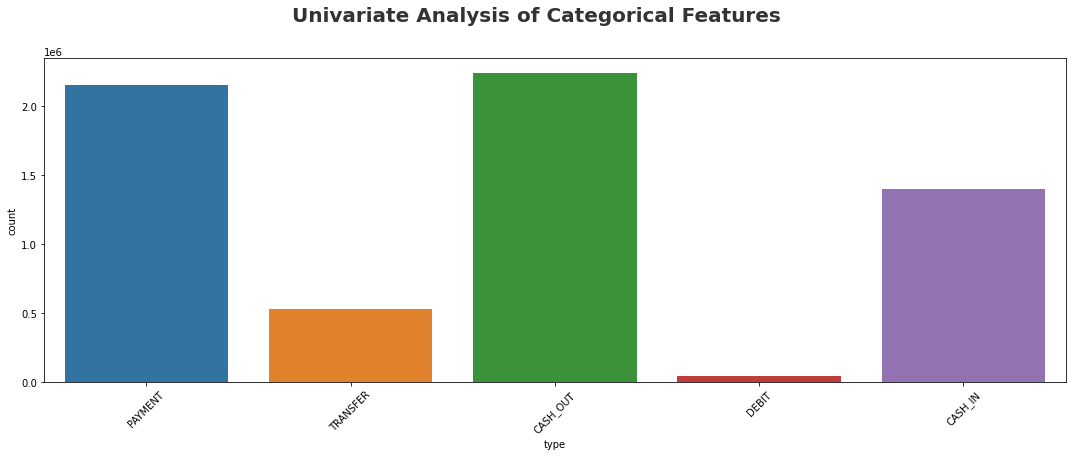

In [23]:
# categorical columns
plt.figure(figsize=(15,50))
plt.suptitle('Univariate Analysis of Categorical Features', fontsize=20, fontweight='bold', alpha=0.8, y=1.)
cat1 =['type']
for i in range(0, len(cat1)):
    plt.subplot(9, 1, i+1)
    sns.countplot(x=df[cat1[i]])
    plt.xlabel(cat1[i])
    plt.xticks(rotation=45)
    plt.tight_layout()

In [24]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

## Multivariate Analysis

Multivariate analysis is the analysis of more than one variable.

In [25]:
df[(list(df.columns)[1:])].corr()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


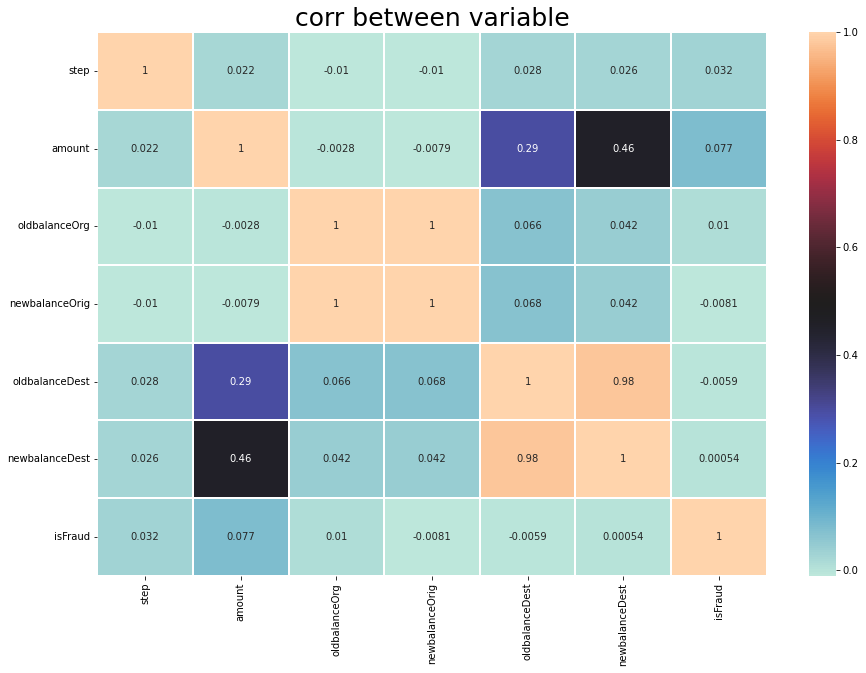

In [26]:
sns.heatmap(df.corr(),annot=True,cmap='icefire',linewidths=0.3)
fig=plt.gcf()
fig.set_size_inches(15,10)
plt.title("corr between variable",color='black',size=25)
plt.show()

- oldbalanceOrg and newbalanceOrig are highly collinear 
- oldbalanceDest and newbalanceDest are highly collinear 
- conclusion - so these fetures are multi collinear , and we have to remove Multicollinearity

**continious fearures**

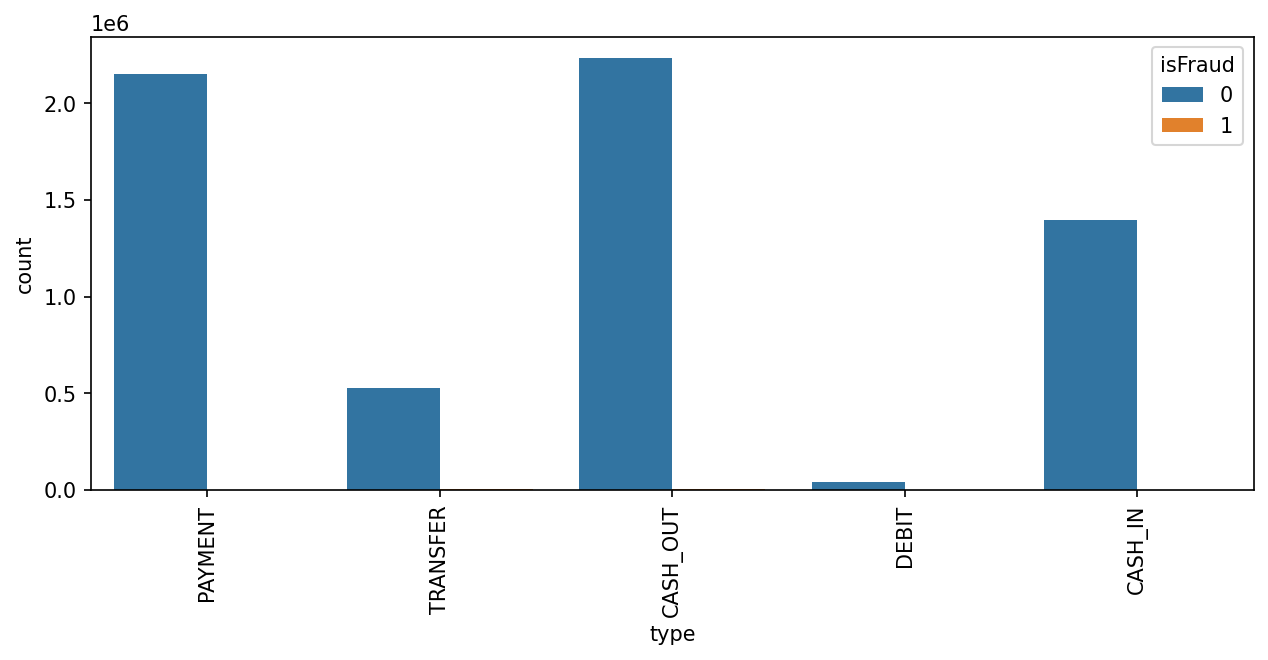

In [27]:
plt.figure(figsize = (10,4), dpi =150)
sns.countplot(data = df, x = 'type', hue = 'isFraud')
plt.xticks(rotation = 90);

- not able to visulize it properly

In [28]:
df.groupby("type")["isFraud"].value_counts().sort_values()

type      isFraud
TRANSFER  1             4097
CASH_OUT  1             4116
DEBIT     0            41432
TRANSFER  0           528812
CASH_IN   0          1399284
PAYMENT   0          2151495
CASH_OUT  0          2233384
Name: isFraud, dtype: int64

In [29]:
df[df["isFraud"]==1]["type"].value_counts(normalize=True)

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

Type: fraud transactions when looked in terms of unique values in column type (which is basically column for transaction type) is only given by two types of transaction CASH_OUT (50.11567) TRANSFER (49.88433), what that means is all fraud transactions are either cash_out or transfer of amount to different account which makes sense as fraud transaction will be done either taking fraud money out from someone's account or transferring it to diffferent account. I mapped 1 to both cash_out and transfer and 0 to other values , so basically I weighted them and give more preference for genuine reason.

**Step Vs isFraud**

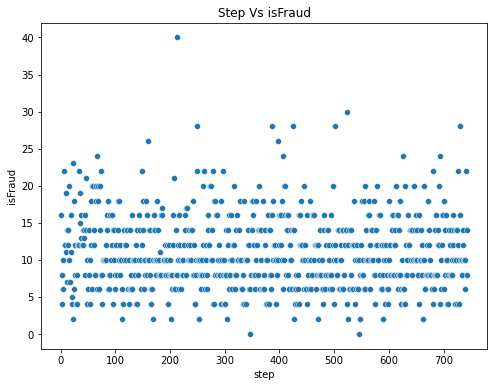

In [30]:
step_group =df.groupby('step').sum().reset_index()
plt.figure(figsize=(8,6))
sns.scatterplot(data=step_group,x='step',y='isFraud')
plt.title('Step Vs isFraud')
plt.show()

no relationship exists between time and fraudulent transactions

## Data Preprocessing

- befor doing preprocessing we have to split our data

In [31]:
# Splitting features and target 
X = df.drop(['isFraud','nameOrig','nameDest'],axis=1)
y = df['isFraud']

In [32]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0


In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(X["type"])

LabelEncoder()

In [34]:
list(label_encoder.classes_)

['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']

In [35]:
X["type"]=label_encoder.transform(X["type"])

In [36]:
X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0


In [37]:
# Splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=42)

In [38]:
# since there is no null values so we are moving forward with feature selection

### Feature selection

- pearson correlation

In [39]:
# if two  features are highly correlated ( not w.r.t target i m saying ) .then we can drop one of the feature as it is doing the same thing , for that we specify some threshold value
# taking a threshold value --> given by domain expert
# the time being we are taking threshold =0.95

In [40]:
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [41]:
# giving threshold 95 percent for the time 
threshold=0.95

In [42]:
correlation(X_train,threshold)

{'newbalanceDest', 'newbalanceOrig'}

In [43]:
X_train=X_train.drop(columns=['newbalanceDest','newbalanceOrig'],axis=1)

In [44]:
X_test=X_test.drop(columns=['newbalanceDest','newbalanceOrig'],axis=1)

**Drop Constant Features Using Variance Threshold**

In [45]:
### It will remove  zero variance features
from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(X_train) # you ave to do fit on x_train

VarianceThreshold(threshold=0)

In [46]:
var_thres.get_support()

array([ True,  True,  True,  True,  True])

- so there is no constant feature 

## feature Importance

This technique gives you a score for each feature of your data,the higher the score mor relevant it is

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model=ExtraTreesClassifier()
model.fit(X_train,y_train)

ExtraTreesClassifier()

In [48]:
print(model.feature_importances_)

[0.23332801 0.03641084 0.28328195 0.34599715 0.10098206]


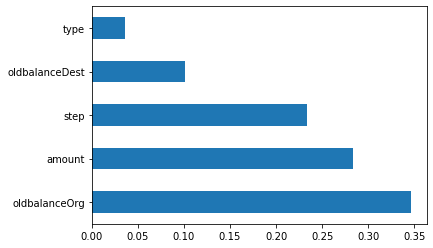

In [49]:
ranked_features=pd.Series(model.feature_importances_,index=X_train.columns)
ranked_features.nlargest(10).plot(kind="barh")
plt.show()

imortant fearures are following in decreasing importance or information gain:
- type
- oldbalanceDest
- step
- amount
- oldbalanceOrd

## Handeling Imbalanced data

In [98]:
from imblearn.combine import SMOTETomek

# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)

In [99]:
# Fit the model to generate the data.
X_train, y_train = smt.fit_resample(X_train, y_train)

In [105]:
X_train.shape ,y_train.shape

((8894168, 5), (8894168,))

# standardize the datasets

**Why Robust scaler and not Standard scaler?**

- Scaling the data using Robust scaler
- Since most of the independent variables are not normally distributed we cannot use Standardscaler

**Why Robust Scaler and not Minmax?**

- because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
- This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [106]:
# Fit with robust scaler for KNN best K-selection experminet
robustscaler = RobustScaler()
s_x_train = robustscaler.fit_transform(X_train)
s_x_test  = robustscaler.transform(X_test)

## model building

In [118]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [119]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X_train, X_test, y_train, y_test, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    accuracy_list = []
    F1_score_list=[]
    Precision_list=[]
    Recall_list=[]
    
    
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)



        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)


        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))


        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        
        accuracy_list.append(model_test_accuracy)
        F1_score_list.append(model_test_f1)
        Recall_list.append(model_test_recall)
        Precision_list.append(model_test_precision)
 
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, accuracy_list, F1_score_list, Recall_list, Precision_list)), columns=['Model Name', 'accuracy','F1_score','Recall','Precision']).sort_values(by=["F1_score"])
        
    return report

In [126]:
# Dictionary which contains models for experiment
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(n_jobs=-1),
     "K-Neighbors Classifier": KNeighborsClassifier(n_jobs=-1),
    "XGBClassifier": XGBClassifier(n_jobs=-1), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False,),
    "AdaBoost Classifier": AdaBoostClassifier()
}

**Fit data for models in dictionary**

In [127]:
evaluate_models(s_x_train, s_x_test, y_train, y_test, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 0.9999
- Precision: 1.0000
- Recall: 0.9998
- Roc Auc Score: 0.9999
----------------------------------
Model performance for Test set
- Accuracy: 0.9997
- F1 score: 0.8817
- Precision: 0.9811
- Recall: 0.8006
- Roc Auc Score: 0.9003


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9997
- F1 score: 0.8887
- Precision: 0.9005
- Recall: 0.8772
- Roc Auc Score: 0.9385


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9993
- F1 score: 0.6476
- Precision: 0.9632
- Recall: 0.4878
- Roc Auc Score: 0.7439
----------------------------------
Model performance for Test set
- Accuracy: 0.9993
- F1 score: 0.6487
- Precision: 0.9612
- Recall: 0.4895
- Roc Auc Score: 0.7447


Logistic Regression
Model performance for Training 

,Model Name,accuracy,F1_score,Recall,Precision
3,Logistic Regression,0.999090,0.512626,0.375926,0.805556
2,Gradient Boosting,0.999325,0.648671,0.489506,0.961212
7,AdaBoost Classifier,0.999371,0.688690,0.546914,0.929696
4,K-Neighbors Classifier,0.999450,0.760766,0.687037,0.852221
0,Random Forest,0.999727,0.881713,0.800617,0.981089
1,Decision Tree,0.999720,0.888680,0.877160,0.900507
6,CatBoosting Classifier,0.999796,0.916801,0.880864,0.955794
5,XGBClassifier,0.999826,0.928223,0.882099,0.979438


**Report**

From the final report we can see than XGBClassifier has performed the best out of other models , 
we not going to do grid search cv as the accuracy is good and to save computation resources 


**1. Data cleaning including missing values, outliers and multi-collinearity.**

   IN this dataset there is no null values ,most of the numerical Features are having outliers but in this case outliers are important ,so not going to remove any outliers and by using  pearson correlation we are handeling multi-collinearity that is if two  features are highly correlated ( not w.r.t target i m saying ) .then we can drop one of the feature as it is doing the same thing , for that we specify some threshold value
   
   taking a threshold value --> given by domain expert
   
   for the  time being we are taking threshold =0.95


**2. Describe your fraud detection model in elaboration.**

A  model for predicting fraudulent transactions for a financial company where the column 'fraud' is simply our  target variable where transaction is indeed a fraudulent transaction .

major steps to build our model

1.  data collection - As the data is provided in the assignment , so it is not a difficult task in data ingestion

2. EDA- Analyzing the data by doing univariate and multivariate analysis by ploting different graphs

3. feature engineering - i.e Data Preprocessing  this includes handeling null values , Encoding categorical data , handeling imbalance data and scaling of the data

4.  model building - building machine learning models on top of training data

5. model evaluation - testing our model on testing data  and selecting the best model 

6. hyperparameter tuning - by using grid search cv we are tuning the parameters of that model which is giving good results previously in ore case  XGBClassifier has performed the best out of other models ,

 note :-
 
 in our case grid search cv is taking too much resorces so we not performing this step  and also we are getting good result we our default model ( XGBClassifier )

**3. How did you select variables to be included in the model?**

- while doing eda I found out that nameOrig , nameDest have too much classes , especially number of classes in nameOrig is same as tota record so these twp features will not contribute in our prediction 

- From the data explanation, anything transfer between accounts bigger then 200.000 would be ifFlaggedFraud == 1. But it is interesting when you take a look at the data that is not the reality. A lot of transactions that are passing of 200.000 between accounts and isFlaggedFraud == 0 and isFraud==1 , so we are no going to use this features 

- using  pearson correlation we are handeling multi-collinearity that is if two  features are highly correlated then we can drop one of the feature , in our case

oldbalanceOrg and newbalanceOrig are highly collinear  , so we are going to drop one the feature

oldbalanceDest and newbalanceDest are highly collinear , so we are going to drop one the feature

- Drop Constant Features Using Variance Threshold  - in our case there is no feature which is constant we are not going to remove any feature


**4. Demonstrate the performance of the model by using best set of tools.**

-  check the performance of the model from 
 Accuracy, F1 score,Precision ,Recall , Roc Auc Score
    but more importantly i am focusing on F1 score because is the harmonic mean of Precision and Recall
    
- also in our case we have to reduce False neagtive 

**5. What are the key factors that predict fraudulent customer?**

- When we look at the oldbalance and newbalance of both origin and destination, we can see some patterns during fraudulent transactions
- Type: fraud transactions when looked in terms of unique values in column type (which is basically column for transaction type) is only given by two types of transaction CASH_OUT (50.11567) TRANSFER (49.88433), what that means is all fraud transactions are either cash_out or transfer of amount to different account which makes sense as fraud transaction will be done either taking fraud money out from someone's account or transferring it to diffferent account. I mapped 1 to both cash_out and transfer and 0 to other values , so basically I weighted them and give more preference for genuine reason.

**6. Do these factors make sense? If yes, How? If not, How not?**

yes these factors make sense 

1. In fraudulent transactions, the origin account is completely emptied out => so we should mark all the transactions where the newbalance becomes zero after cashout or transfer AS 1 (possible fraud)

2. On the other hand, in normal transactions, the newbalance in the destination account typically increases by the equivalent of the transaction amount. But in fraudulent transactions, they do not increase by that transaction amount => there is an anomaly => so we should mark all such anomalous transactions AS 1 (possible fraud)

3. Similarly, in fraudulent transactions, the newbalance in the destination account does not increase at all => means newbalance in Destination is zero whether the transaction is transfer or cashout => so we should mark all such transactions AS 1 (possible fraud)

**7. What kind of prevention should be adopted while company update its infrastructure?**
- The company should contact the account holder as soon as the transaction amount crosses some threshold value(specified by domain expert ) of their balance in account and should not let them totally empty their account, by that they can significantly decrease fraudlent transaction.



**8. Assuming these actions have been implemented, how would you determine if they work?**

To check the efficiency of step above actions, they should check data drift i.e is there is any change with new data nd  EDA to do analysis on top of that  new data  to check for the fraudlent transaction . If there is a decrease fraudlent transaction then it is great , but if fraudlent transaction are still same or increasing then we should take the advise from the domain expert 